# Appendix A: Identifying the near-Antarctic class

In [1]:
### modules in this package
import load_and_preprocess as lp
import analysis as at
import bic_and_aic as ba
import plot_tools as pt
import file_io as io
import xarray
import density
import gmm
### plotting tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import cmocean 
### os tools
import os.path

# Suppress a particular warning
import warnings
warnings.filterwarnings('ignore', 'RuntimeWarning: All-NaN slice encountered')

In [2]:
# set locations and names
descrip = 'allDomain' # extra description for filename
data_location = '../../so-chic-data/' # input data location
ploc = 'plots/plots_allDomain_top1000m_K05_forPaper/'
dloc = 'models/'

# if plot directory doesn't exist, create it
if not os.path.exists(ploc):
    os.makedirs(ploc)

# calculate BIC and AIC? set max number of components
getBIC = False
max_N = 20

# save the processed output as a NetCDF file?
saveOutput = False

# number of PCA components
# --- EXPLAINED VARIANCE Is = 0.95
n_pca = 6

# make decision about n_components_selected (iterative part of analysis)
n_components_selected = 5

#longitude and latitude range
lon_min = -65
lon_max =  80
lat_min = -85
lat_max = -30
# depth range
zmin = 20.0
zmax = 1000.0
# lat/lon range 
lon_range=(lon_min, lon_max)
lat_range=(lat_min, lat_max)

# density range
sig0range = (23.0, 28.0)

# temperature and salinity ranges for plotting
Trange=(-2, 25.0)
Srange=(33.0, 37.0)

# create filename for saving GMM and saving labelled profiles
pca_fname = dloc + 'pca_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + \
                   'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + \
                str(int(n_pca)) + descrip
gmm_fname = dloc + 'gmm_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + \
                   'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + \
                   str(int(n_components_selected)) + 'K_' + descrip
fname = dloc + 'profiles_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + \
               'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + \
               str(int(n_components_selected)) + 'K_' + descrip + '.nc'

#
# colormap (to be used across all plots)
#
colormap = plt.get_cmap('Dark2', n_components_selected)
colormap_cividis = plt.get_cmap('cividis', 20)

In [3]:
# load profile subset based on ranges given above
profiles = lp.load_profile_data(data_location, lon_min, lon_max,
                                lat_min, lat_max, zmin, zmax)

# preprocess date and time
profiles = lp.preprocess_time_and_date(profiles)

# calculate conservative temperature, absolute salinity, and density (sig0)
profiles = density.calc_density(profiles)

# regrid onto density levels (useful for plotting later)
profiles = lp.regrid_onto_more_vertical_levels(profiles, zmin, zmax)
profiles = lp.regrid_onto_density_levels(profiles)

# print some values : how many profiles?
n_argo = profiles.where(profiles.source=='argo',drop=True).profile.size
n_ctd = profiles.where(profiles.source=='ctd',drop=True).profile.size
n_seal = profiles.where(profiles.source=='seal',drop=True).profile.size
n_profiles = n_argo + n_ctd + n_seal
print('******************************************************************')
print('Number of Argo profiles after selection applied = ' + str(n_argo))
print('Number of CTD profiles after selection applied = ' + str(n_ctd))
print('Number of seal profiles after selection applied = ' + str(n_seal))
print('******************************************************************')
print('Total number of profiles after selection applied = ' + str(n_profiles))

load_and_preprocess.load_profile_data
----> profiles loaded
load_and_preprocess.preprocess_time_and_date
density.calc_density
load_and_preprocess.regrid_onto_more_vertical_levels
load_and_preprocess.regrid_onto_density_levels
******************************************************************
Number of Argo profiles after selection applied = 134698
Number of CTD profiles after selection applied = 7636
Number of seal profiles after selection applied = 0
******************************************************************
Total number of profiles after selection applied = 142334


### PCA

In [4]:
# if trained PCA already exists, load it
if os.path.isfile(pca_fname):
    pca = io.load_pca(pca_fname)
    Xtrans = lp.apply_pca(profiles, pca)
# otherwise, go ahead and train it
else:
    # apply PCA
    pca, Xtrans = lp.fit_and_apply_pca(profiles,
                                       number_of_pca_components=n_pca,
                                       train_frac=0.99)
    # save for future use
    io.save_pca(pca_fname, pca)

load_and_preprocess.fit_and_apply_pca
load_and_preprocess.apply_scaling
load_and_preprocess.apply_scaling: using depth levels
Fitting PCA
0.9934019168169493
file_io.save_pca


plot_tools.plot_pca


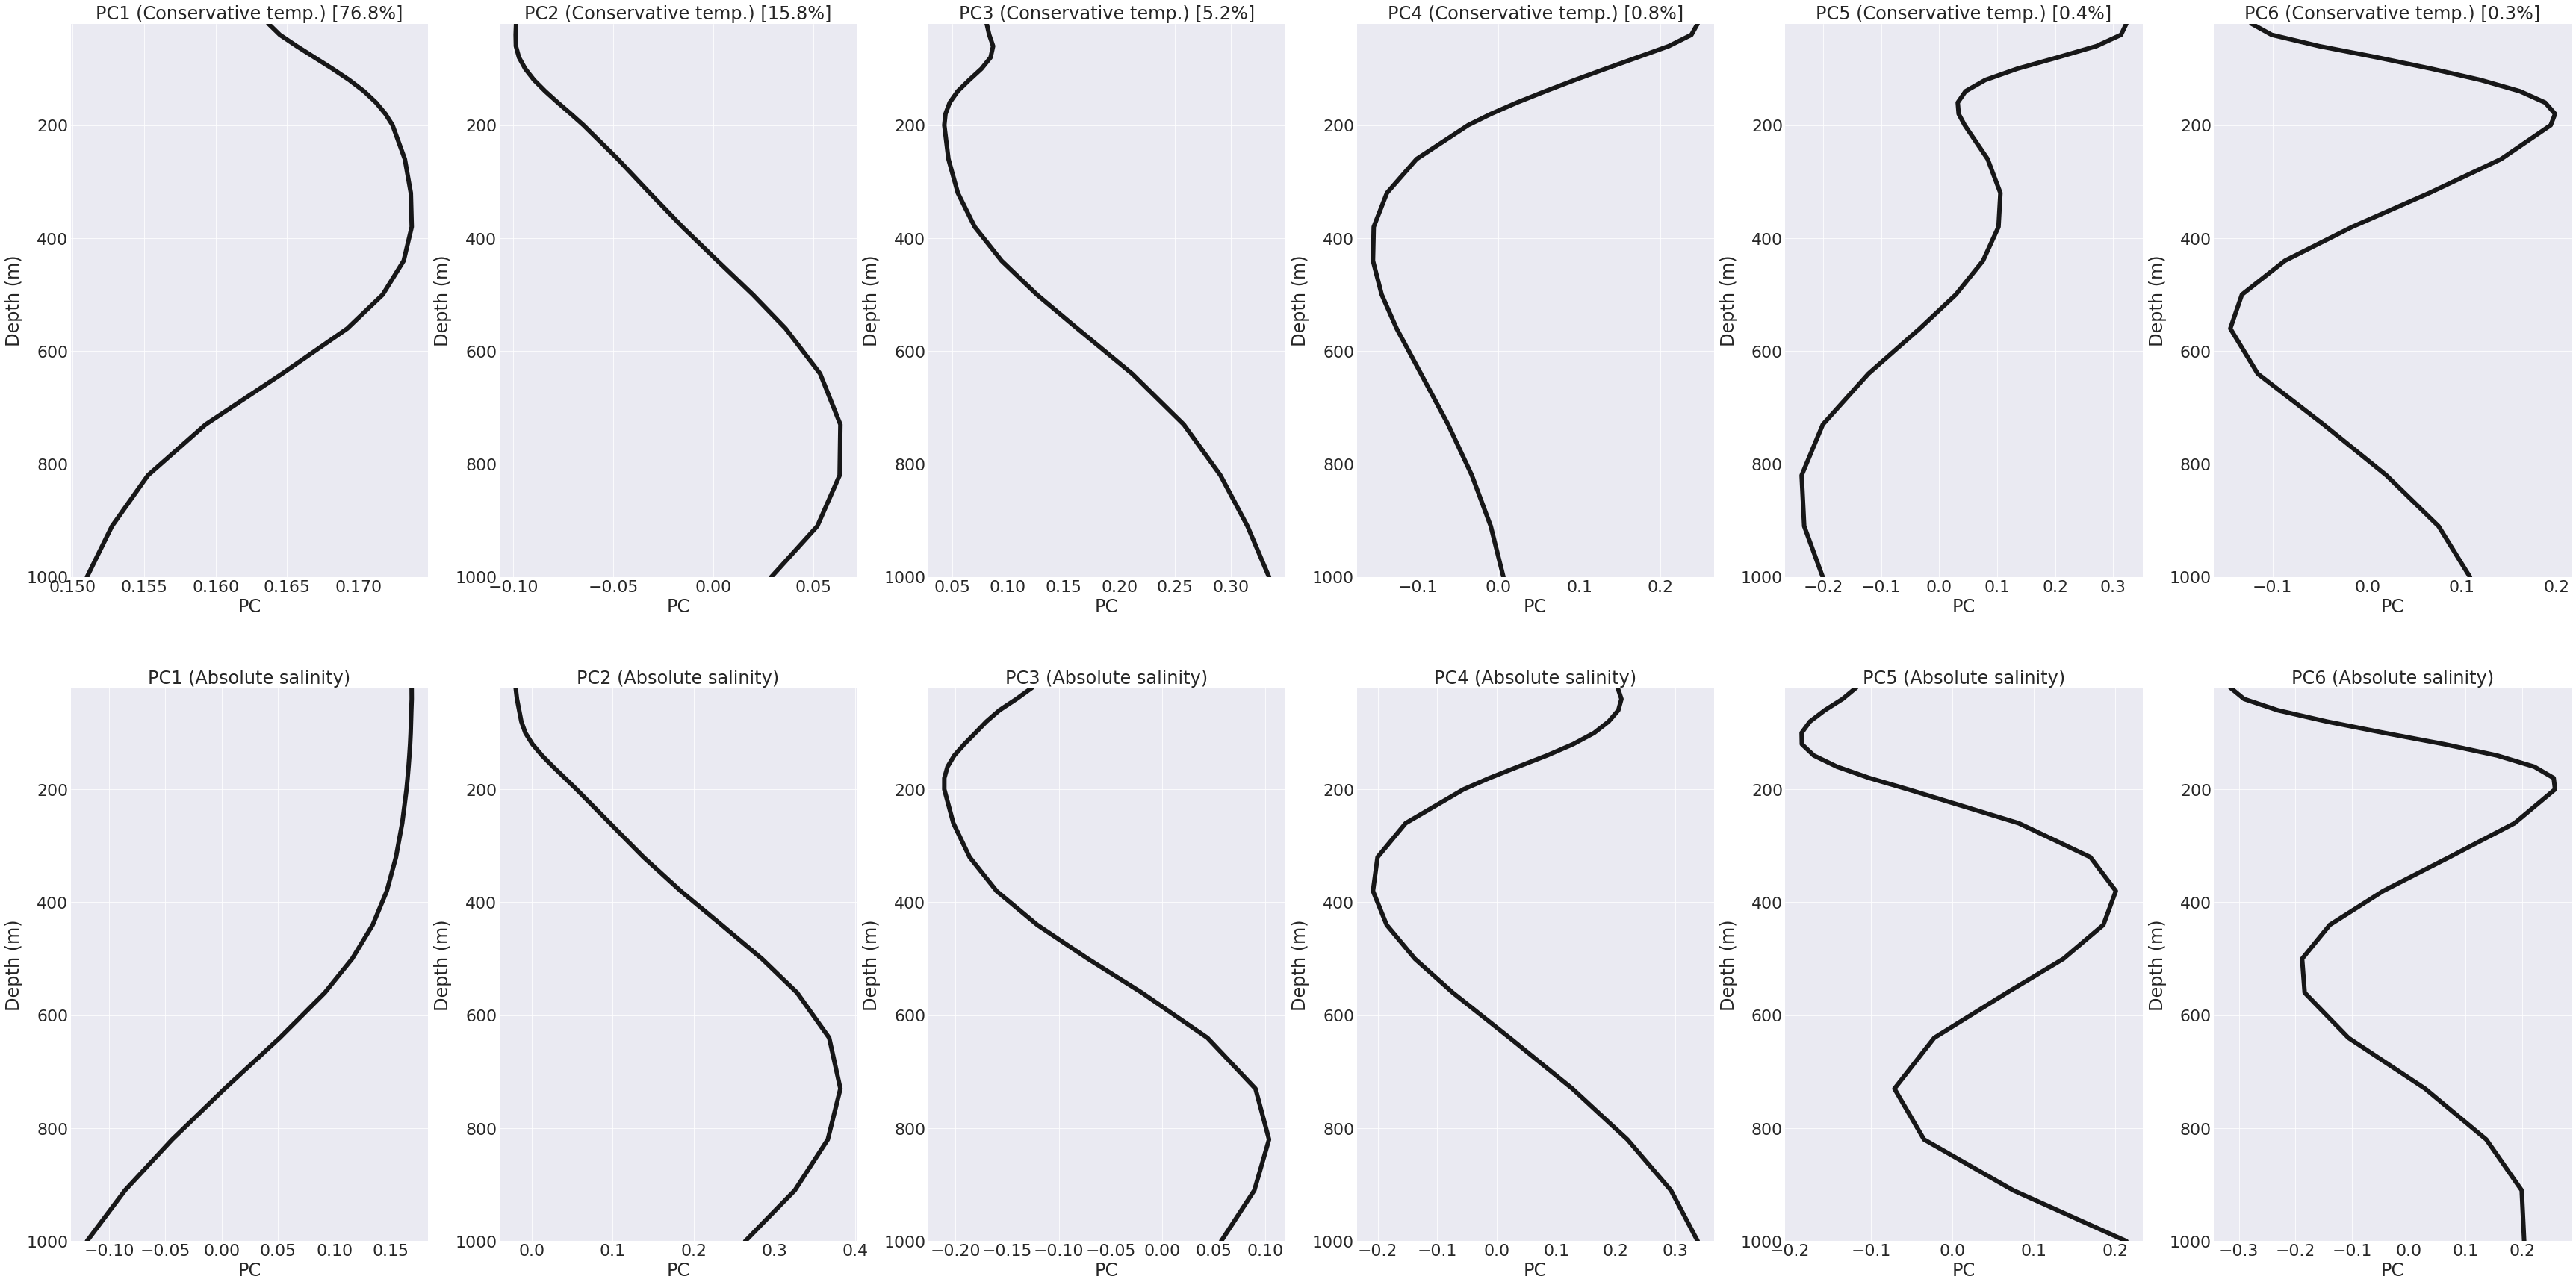

In [5]:
# plot PCA structure
pt.plot_pca_vertical_structure(ploc, profiles, pca, Xtrans)

### BIC and AIC

In [6]:
# calculate BIC and AIC
if getBIC==True:
    bic_mean, bic_std, aic_mean, aic_std = ba.calc_bic_and_aic(Xtrans, max_N)
    pt.plot_bic_scores(ploc, max_N, bic_mean, bic_std)
    pt.plot_aic_scores(ploc, max_N, aic_mean, aic_std)

### GMM

In [7]:
# if GMM exists, load it. Otherwise, create it.
if os.path.isfile(gmm_fname):
    best_gmm = io.load_gmm(gmm_fname)
else:
    best_gmm = gmm.train_gmm(Xtrans, n_components_selected)
    io.save_gmm(gmm_fname, best_gmm)

# apply either loaded or created GMM
profiles = gmm.apply_gmm(profiles, Xtrans, best_gmm, n_components_selected)

# calculate class statistics
class_means, class_stds = gmm.calc_class_stats(profiles)

gmm.train_gmm
file_io.save_gmm
gmm.apply_gmm
gmm.calc_class_stats


plot_tools.plot_pca3D


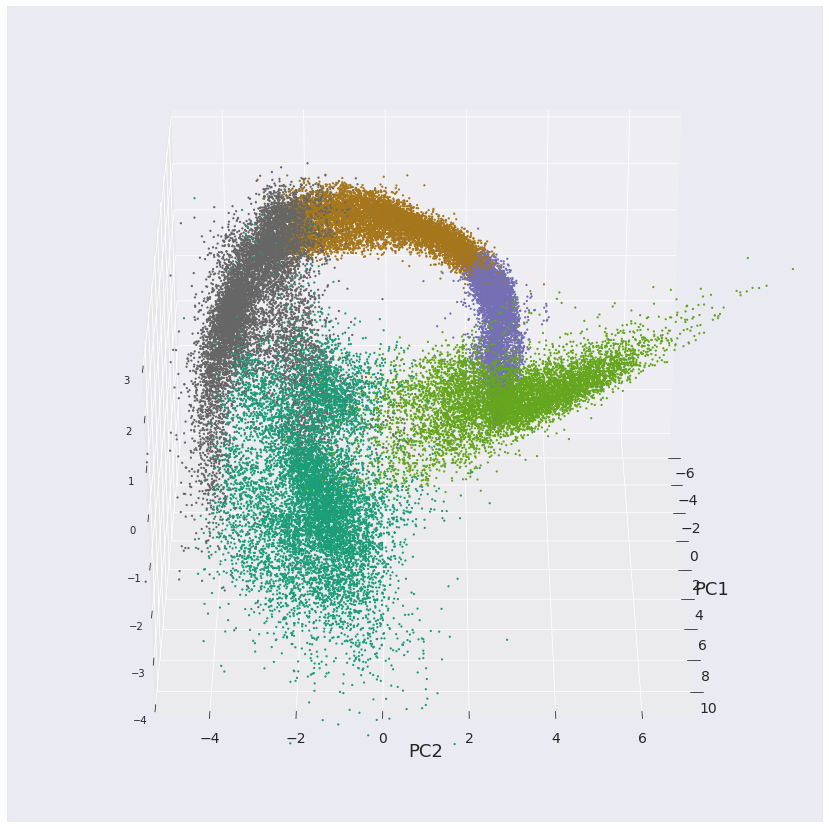

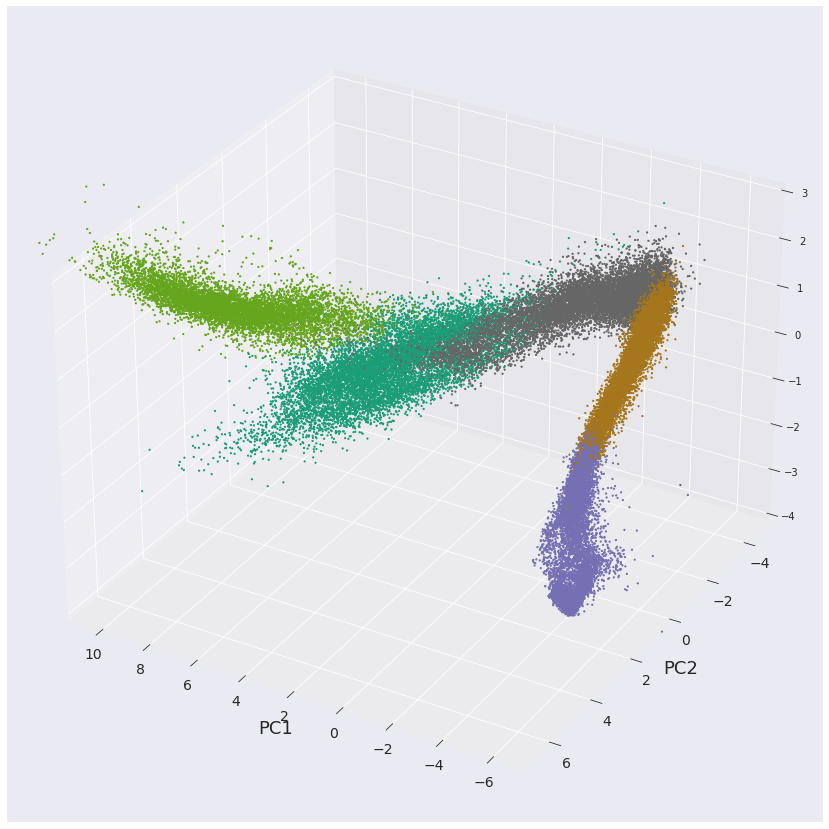

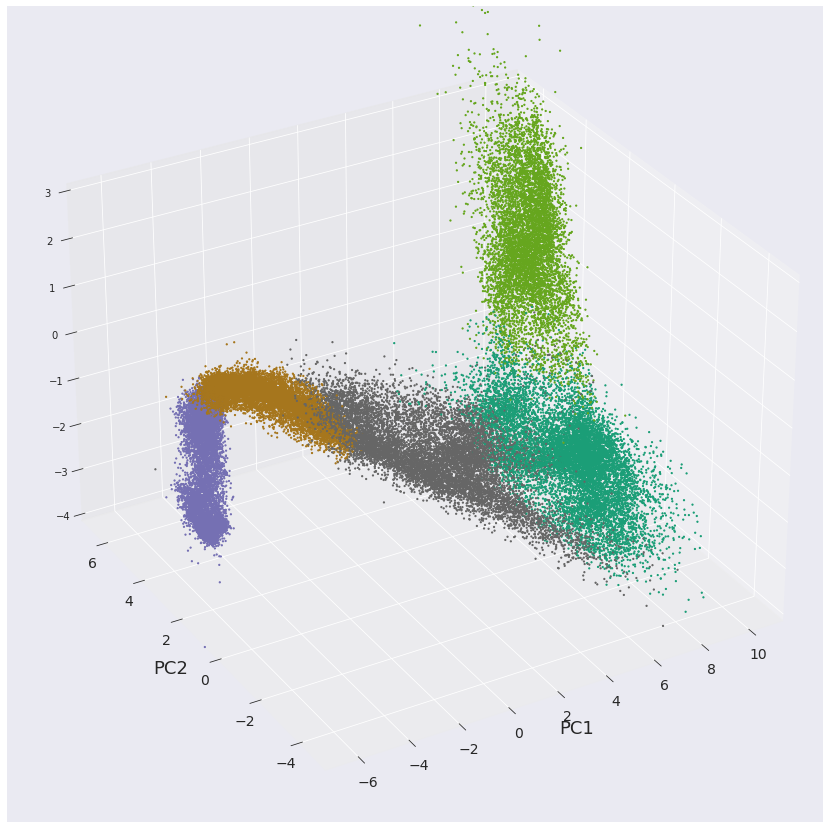

In [8]:
# scatterplot of PCA values (3D) 
pt.plot_pca3D(ploc, colormap, profiles, Xtrans, frac=0.33, withLabels=True)

In [9]:
# simplify Dataset for plotting purposes
dfp = profiles
df_imetric = gmm.calc_i_metric(profiles)

# 
dfp['Tmin'] = dfp.prof_CT.min(dim='depth')
dfp['Tmax'] = dfp.prof_CT.max(dim='depth')
dfp['Smin'] = dfp.prof_SA.min(dim='depth')
dfp['Smax'] = dfp.prof_SA.max(dim='depth')
dfp['sig0min'] = dfp.sig0.min(dim='depth')
dfp['sig0max'] = dfp.sig0.max(dim='depth')
dfp['imetric'] = df_imetric.i_metric

# look at contents of Dataset
dfp

gmm.calc_i_metric


<xarray.Dataset>
Dimensions:        (profile: 142334, depth: 21, depth_highz: 50, sig0_levs: 100, CLASS: 5)
Coordinates:
  * profile        (profile) int64 0 1 2 3 4 ... 142330 142331 142332 142333
    lon            (profile) float64 dask.array<chunksize=(477,), meta=np.ndarray>
    lat            (profile) float64 dask.array<chunksize=(477,), meta=np.ndarray>
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] 1972-11-20T12:00:00 ... 2020-10-1...
    year           (profile) int64 1972 1972 1972 1972 ... 2020 2020 2020 2020
    month          (profile) int64 11 11 11 12 12 12 12 ... 10 10 10 10 10 10 10
  * depth_highz    (depth_highz) float64 20.0 40.0 60.0 ... 960.0 980.0 1e+03
  * sig0_levs      (sig0_levs) float64 22.66 22.72 22.77 ... 27.86 27.91 27.97
  * CLASS          (CLASS) int64 0 1 2 3 4
Data variables: (12/23)
    prof_date      (profile) float64 dask.array<chunksize=(477,), meta=np.ndarray>
    prof_YYYYMMDD  (profile) float64 dask.array<chunksize=(477,), meta=np.ndarray>
    prof_HHMMSS    (profile) float64 dask.array<chunksize=(477,), meta=np.ndarray>
    prof_T         (profile, depth) float64 dask.array<chunksize=(477, 21), meta=np.ndarray>
    prof_S         (profile, depth) float64 dask.array<chunksize=(477, 21), meta=np.ndarray>
    source         (profile) object dask.array<chunksize=(477,), meta=np.ndarray>
    ...             ...
    Tmax           (profile) float64 dask.array<chunksize=(477,), meta=np.ndarray>
    Smin           (profile) float64 dask.array<chunksize=(477,), meta=np.ndarray>
    Smax           (profile) float64 dask.array<chunksize=(477,), meta=np.ndarray>
    sig0min        (profile) float64 dask.array<chunksize=(477,), meta=np.ndarray>
    sig0max        (profile) float64 dask.array<chunksize=(477,), meta=np.ndarray>
    imetric        (profile) float64 5.494e-11 5.325e-11 ... 3.318e-13 1.96e-11

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

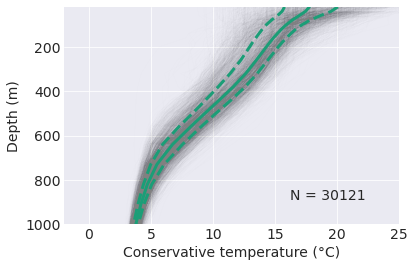

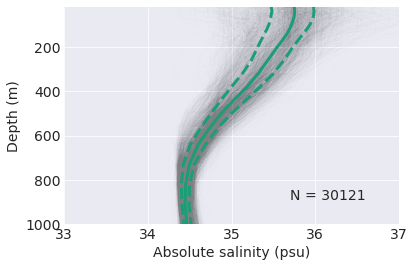

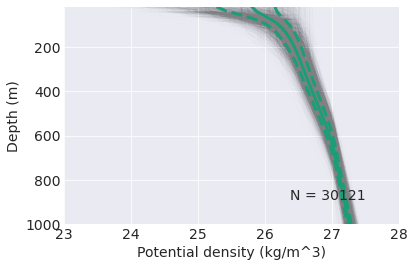

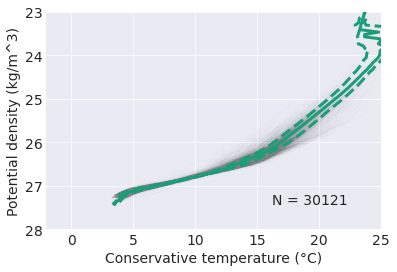

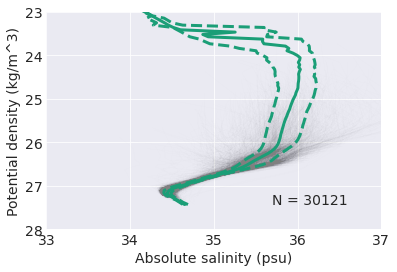

plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

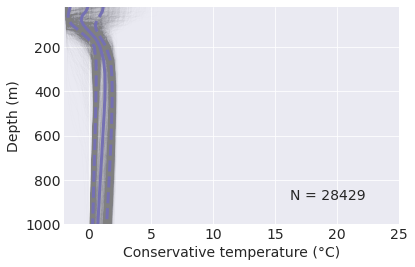

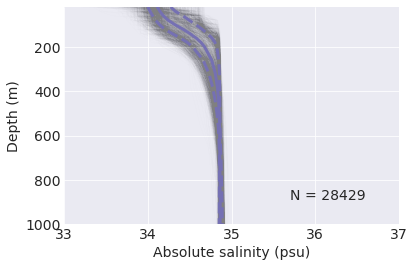

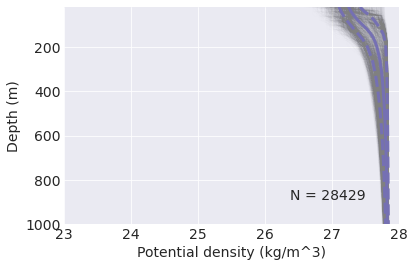

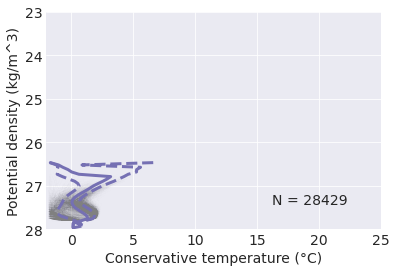

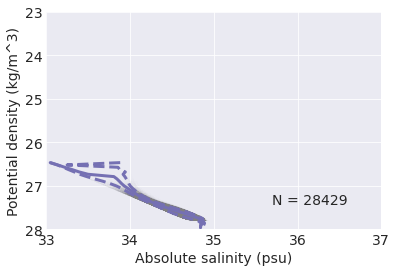

plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

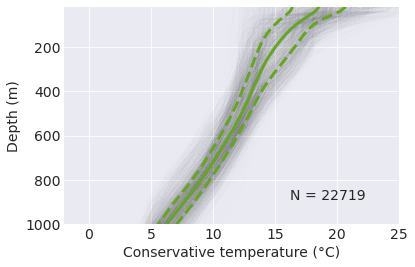

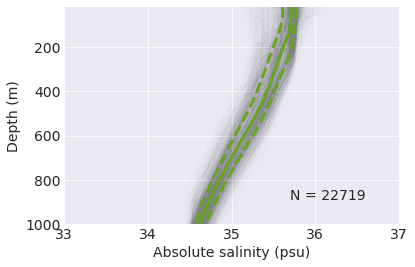

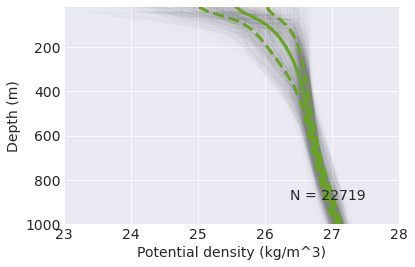

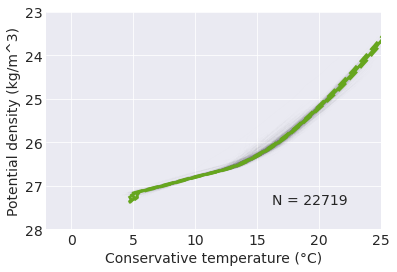

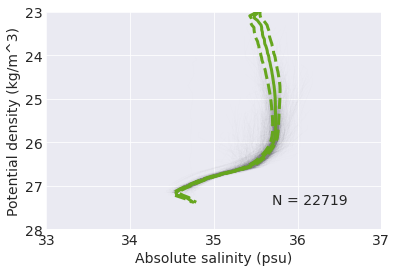

plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

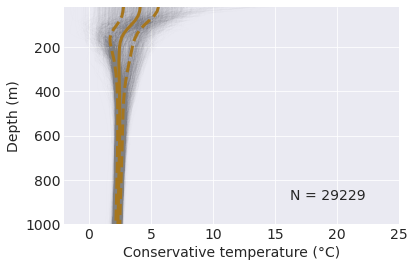

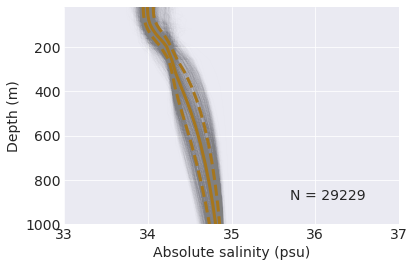

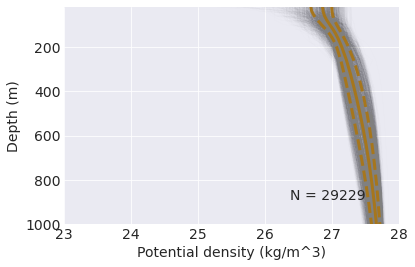

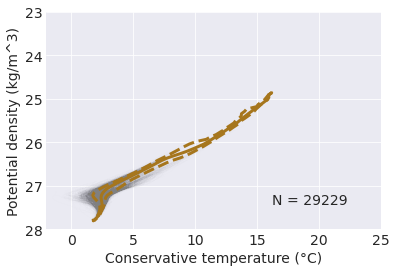

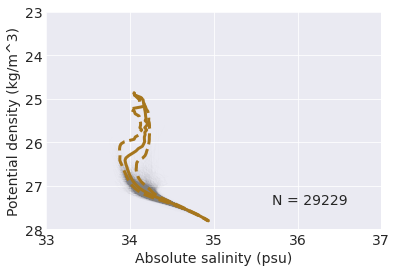

plot_tools.plot_many_profiles


/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/na

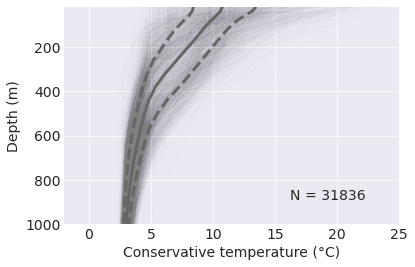

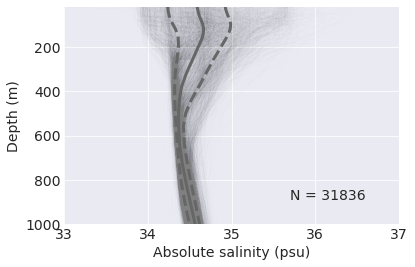

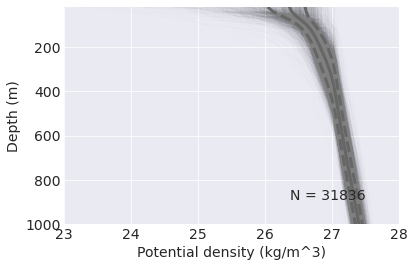

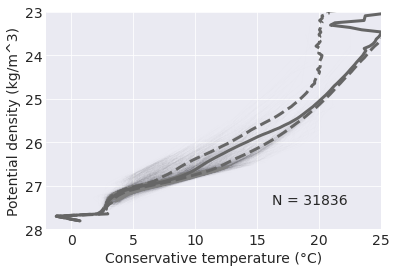

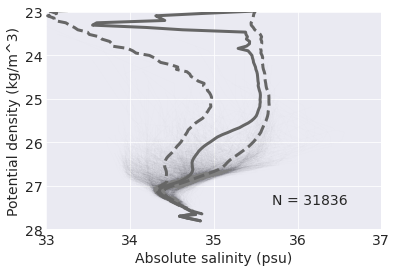

In [10]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, profiles, n_components_selected, colormap,
                                  zmin=zmin, zmax=zmax,
                                  Tmin=Trange[0], Tmax=Trange[1],
                                  Smin=Srange[0], Smax=Srange[1],
                                  sig0min=sig0range[0], sig0max=sig0range[1],
                                  frac=0.10)

plot_tools.plot_hist_map
file_io.load_bathymetry


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


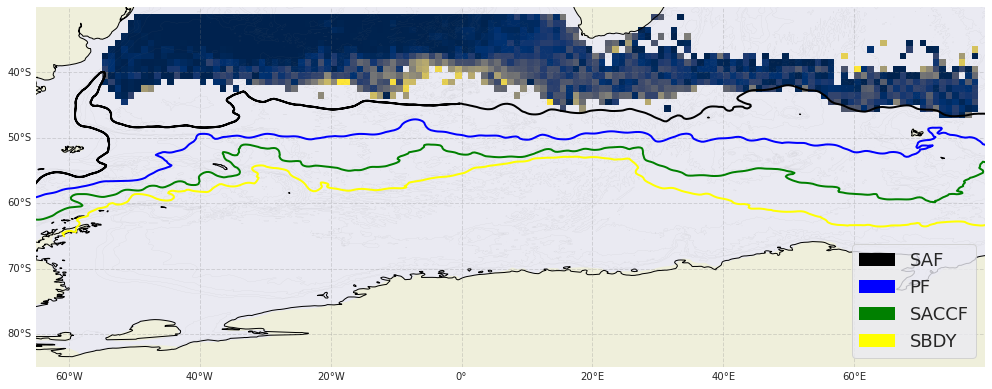

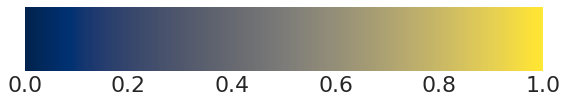

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


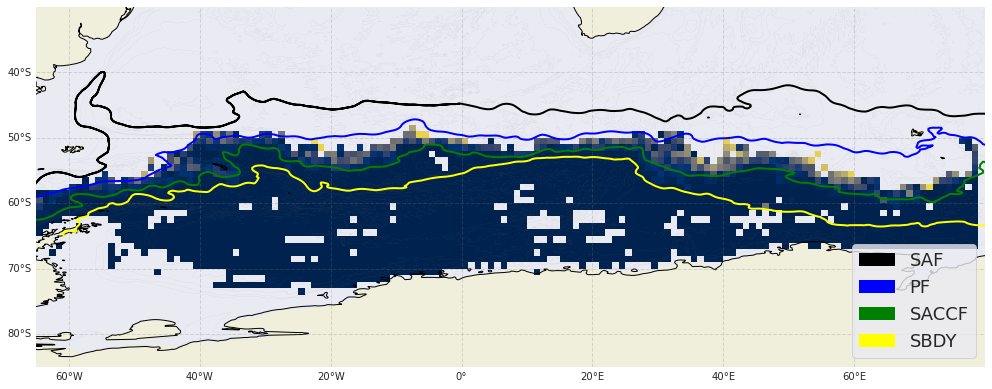

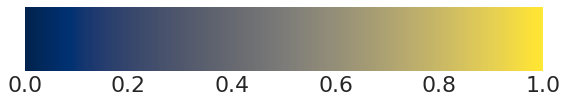

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


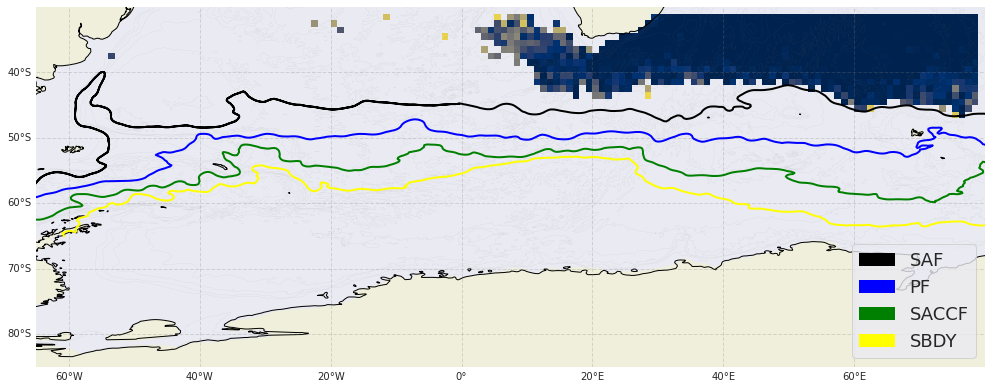

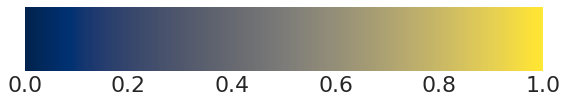

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


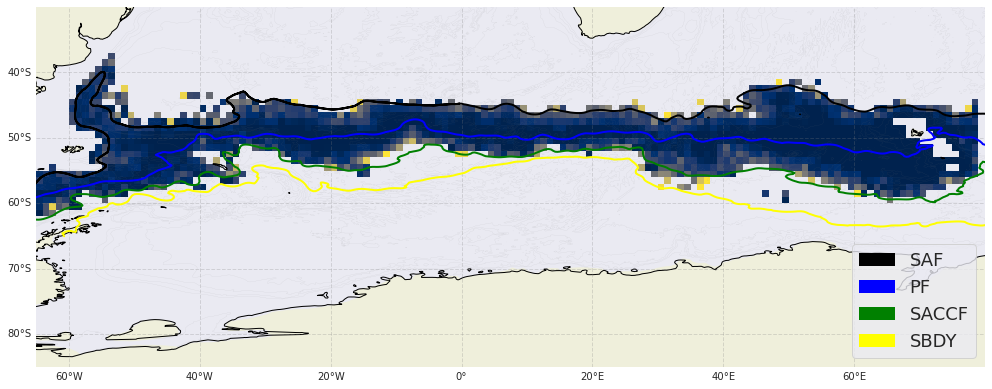

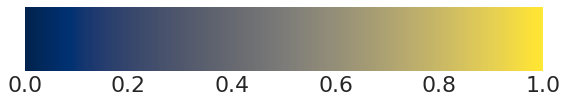

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


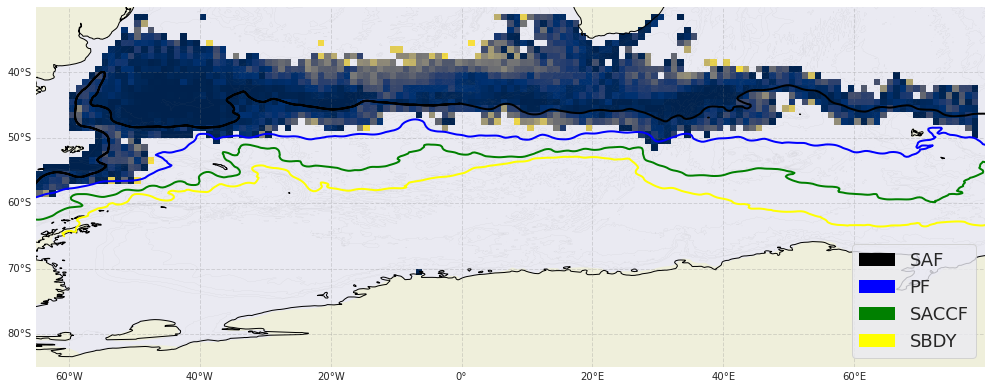

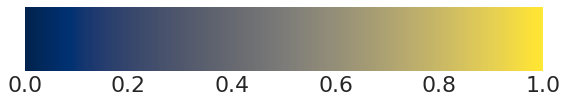

In [11]:
pt.plot_hist_map(ploc, dfp, lon_range, lat_range,
                 n_components_selected,
                 c_range=(0,1),
                 vartype='imetric',
                 colormap=plt.get_cmap('cividis'))